In [1]:
"""
this script contains functions to visualize the different attributes
Author: Nathan Greffe
"""
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle
import pandas as pd
import numpy as np
from collections import OrderedDict
from matplotlib.lines import Line2D

In [2]:
results = pd.read_csv('architectures.csv')
results = results[np.logical_not(results.acc3.isnull())]
results.reset_index(inplace=True)
results['time'] = results['time'] * 1000
results['error'] = 100*(1.0 - results[['acc1', 'acc2', 'acc3']].mean(axis=1))
results['error_std'] = 100*results[['acc1', 'acc2', 'acc3']].std(axis=1)
results.head()

,index,file_name,arch,depth,width,other,acc1,acc2,acc3,time,error,error_std
0,0,squeezenext_d9_w48_cosine,squeezenext,9,48,NaN,0.9168,0.9184,0.9049,52.7,8.663333,0.737586
1,1,effnet_d12_w32_e4_cosine,effnet,12,32,4.0,0.9035,0.9080,0.9030,21.5,9.516667,0.275379
2,2,shufflenetv1_d9_w80_g2_cosine,shufflenetv1,9,80,2.0,0.9107,0.9057,0.9048,50.7,9.293333,0.317857
3,3,shufflenetv2_d12_w64_cosine,shufflenetv2,12,64,NaN,0.9238,0.9242,0.9230,44.1,7.633333,0.061101
4,4,shufflenetv2_d18_w80_cosine,shufflenetv2,18,80,NaN,0.9347,0.9373,0.9345,93.0,6.450000,0.156205


In [3]:
results_val = pd.read_csv('architectures_val.csv')
results_val['time'] = results_val['time'] * 1000
results_val['error'] = 100*(1.0 - results_val['acc'])
results_val.head()

,file_name,arch,depth,width,other,acc,time,error
0,effnet_d12_e2_cosine,effnet,12,2,NaN,0.8902,10.2,10.98
1,effnet_d12_e3_cosine,effnet,12,32,3.0,0.9038,15.3,9.62
2,effnet_d12_e4_cosine,effnet,12,32,4.0,0.9102,21.5,8.98
3,effnet_d15_e2_cosine,effnet,15,2,NaN,0.8888,10.1,11.12
4,effnet_d15_e3_cosine,effnet,15,32,3.0,0.8964,15.4,10.36


In [4]:
pruning_wrn_res = pd.read_csv('../NetAdapt/pruning_methods.csv')
pruning_wrn_res['table_time'] = pruning_wrn_res['table_time'] * 1000
pruning_wrn_res['measured_time'] = pruning_wrn_res['measured_time'] * 1000
pruning_wrn_res = pruning_wrn_res[np.logical_or(
    pruning_wrn_res.method == 'unpruned',
    np.logical_and(pruning_wrn_res.method == 'fisher_table', 
    pruning_wrn_res.criterion.isnull()))]  # we take the unpruned + fisher table WRNs
pruning_wrn_res.head()

,file_name,no_fine_tune,fine_tune,retrain_scratch,table_time,measured_time,method,criterion
39,res-40-2-table_fisher-pf=0.8-150ch,5.28,NaN,4.97,284.2,285.6,fisher_table,NaN
40,res-40-2-table_fisher-pf=0.8-300ch,5.39,NaN,5.25,243.1,240.4,fisher_table,NaN
41,res-40-2-table_fisher-pf=0.8-450ch,5.29,NaN,5.36,220.5,222.0,fisher_table,NaN
42,res-40-2-table_fisher-pf=0.8-600ch,7.52,NaN,5.71,168.6,166.8,fisher_table,NaN
43,res-40-2-table_fisher-pf=0.8-750ch,15.80,NaN,5.92,119.3,117.9,fisher_table,NaN


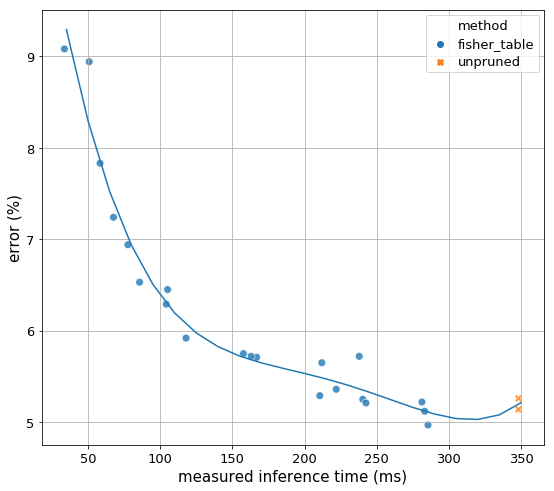

In [5]:
# fits a polynom
polynom = np.poly1d(np.polyfit(pruning_wrn_res.measured_time, 
                               pruning_wrn_res.retrain_scratch, 4))

fig, ax = plt.subplots(1, figsize=(9, 8))
sns.scatterplot(x="measured_time", y="retrain_scratch", data=pruning_wrn_res, hue='method', 
                style='method', legend='brief', ax=ax, s=60, alpha=0.8)
plt.plot(np.arange(35,351,15), polynom(np.arange(35,351,15)))
ax.set_xlabel('measured inference time (ms)', fontsize=15)
ax.set_ylabel('error (%)', fontsize=15)
ax.grid(True)

plt.setp(ax.get_legend().get_texts(), fontsize='13') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title
ax.tick_params(axis='both', which='major', labelsize=13)  # for ticks

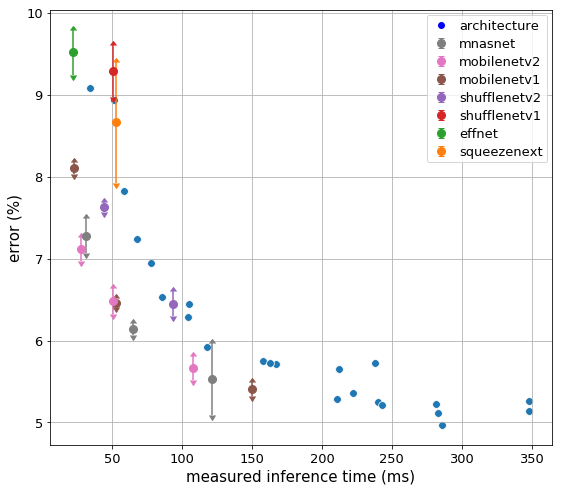

In [16]:
displays_SE = False
displays_WRN = False

_, idx = np.unique(results.arch, return_index=True)
color_labels = results.arch[np.sort(idx)]
rgb_values = sns.color_palette(n_colors=color_labels.shape[0]+1)[1:]  # skips blue which is 
# already used
color_map = dict(zip(color_labels, rgb_values))
colors = results.arch.map(color_map)

fig, ax = plt.subplots(1, figsize=(9, 8))
sns.scatterplot(x="measured_time", y="retrain_scratch", data=pruning_wrn_res, legend='brief', 
                ax=ax, s=60)
# plt.plot(np.arange(35,351,15), polynom(np.arange(35,351,15)))
for i in range(results.shape[0]):
    if (displays_SE or ('se' not in results.file_name[i])) and \
    (not displays_SE or results.arch[i] not in ['squeezenext', 'effnet', 'shufflenetv1']):  
        # do not displays SE when displays_SE == False and do not show bad arch. when SE == True
        plt.errorbar(results.time[i], 
                     results.error[i],
                     color=colors[i],
                     yerr=results.error_std[i],
                     fmt='x' if 'se' in results.file_name[i] else 'o', 
                     lolims=True, uplims=True,
                     markersize=8, 
                     alpha=.35 if displays_SE and 'se' not in results.file_name[i] else 1,
                     ecolor=colors[i],
                     label=results.arch[i])
ax.set_xlabel('measured inference time (ms)', fontsize=15)
ax.set_ylabel('error (%)', fontsize=15)
ax.grid(True)

handles, labels = plt.gca().get_legend_handles_labels()  # removes duplicates

if displays_SE:
    by_label = OrderedDict(zip(labels, handles))
else:
    by_label = OrderedDict(zip(labels[::-1], handles[::-1])) # so as to have rounds or 
    # crosses in the legend

labels = [i for i in by_label.keys()]
handles = [i for i in by_label.values()]

if displays_SE:
    handles.append(Line2D([0], [0], marker='o', color='w', label='',
                              markerfacecolor='w', markersize=8))
    labels.append('')

    handles.append(Line2D([0], [0], marker='o', color='w', label='',
                              markerfacecolor='w', markersize=8))
    labels.append('SE block')

    handles.append(Line2D([0], [0], marker='o', color='w', label='with',
                              markerfacecolor='k', alpha=0.35, markersize=8))
    labels.append('without')

    handles.append(Line2D([0], [0], marker='X', color='w', label='retrain_scratch',
                              markerfacecolor='k', markersize=8))
    labels.append('with')
    
if displays_WRN:
    handles.append(Line2D([0], [0], marker='o', color='w', label='',
                              markerfacecolor='b', markersize=8))
    labels.append('WRN (fisher_table pruning)')
    
handles = [Line2D([0], [0], marker='o', color='w', label='',
                              markerfacecolor='b' , markersize=8)] + handles
labels = ['architecture'] + labels

ax.legend(handles, labels)
plt.setp(ax.get_legend().get_texts(), fontsize='13') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title
ax.tick_params(axis='both', which='major', labelsize=13)  # for ticks
# plt.savefig(f'arch_comparison{"_SE" if displays_SE else "_WRN" if displays_WRN else ""}.pdf')

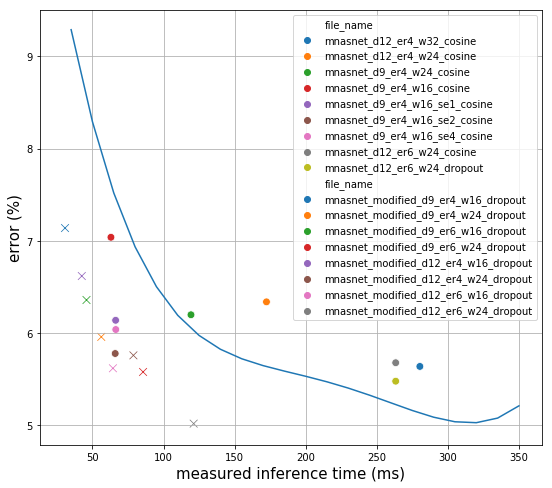

In [7]:
fig, ax = plt.subplots(1, figsize=(9, 8))
offset_modif = results_val[results_val.arch == "mnasnet"].apply(lambda x: 'modif' in x.file_name, axis=1)
results_val_to_plot = results_val[results_val.arch == "mnasnet"][np.logical_not(offset_modif)]
sns.scatterplot(x="time", y="error", data=results_val_to_plot, hue='file_name', 
                legend='brief', ax=ax, s=60, marker='o')
results_val_to_plot = results_val[results_val.arch == "mnasnet"][offset_modif]
sns.scatterplot(x="time", y="error", data=results_val_to_plot, hue='file_name', 
                legend='brief', ax=ax, s=60, marker='x')
plt.plot(np.arange(35,351,15), polynom(np.arange(35,351,15)))
ax.set_xlabel('measured inference time (ms)', fontsize=15)
ax.set_ylabel('error (%)', fontsize=15)
ax.grid(True)